# Data pre process

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
DataFrame = pd.read_excel('./DataSets/Raw_Building_energy_DataSet.xlsx', header=1)

### Basic Info of the data frame 

In [40]:
DataFrame.head()

,Time,reading
0,2021-01-27 11:00:00,8.03 kWh
1,2021-01-27 12:00:00,6.85 kWh
2,2021-01-27 13:00:00,8.86 kWh
3,2021-01-27 14:00:00,7.37 kWh
4,2021-01-27 15:00:00,7.67 kWh


In [41]:
DataFrame.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6726 entries, 0 to 6725
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Time     6726 non-null   object
 1   reading  6726 non-null   object
dtypes: object(2)
memory usage: 105.2+ KB


In [42]:
DataFrame.columns 

Index(['Time', 'reading'], dtype='object')

In [43]:
print(DataFrame['Time'])

0       2021-01-27 11:00:00
1       2021-01-27 12:00:00
2       2021-01-27 13:00:00
3       2021-01-27 14:00:00
4       2021-01-27 15:00:00
               ...         
6721    2021-11-03 12:00:00
6722    2021-11-03 13:00:00
6723    2021-11-03 14:00:00
6724    2021-11-03 15:00:00
6725    2021-11-03 16:00:00
Name: Time, Length: 6726, dtype: object


In [44]:
type(DataFrame['Time'][0])

str

### Removing Units from Reading column

For the input we need a valid integer value, without any string

In [45]:
reading  = [float(s.replace(" kWh",'')) for s in DataFrame['reading']]
#Insert the new values without the units
DataFrame.insert(1, 'Energy Usage',reading)

#Remove the old one
DataFrame.drop('reading', inplace = True, axis=1) 

#check 
DataFrame.head()

,Time,Energy Usage
0,2021-01-27 11:00:00,8.03
1,2021-01-27 12:00:00,6.85
2,2021-01-27 13:00:00,8.86
3,2021-01-27 14:00:00,7.37
4,2021-01-27 15:00:00,7.67


### Plots 

#### Plot Energy Usage

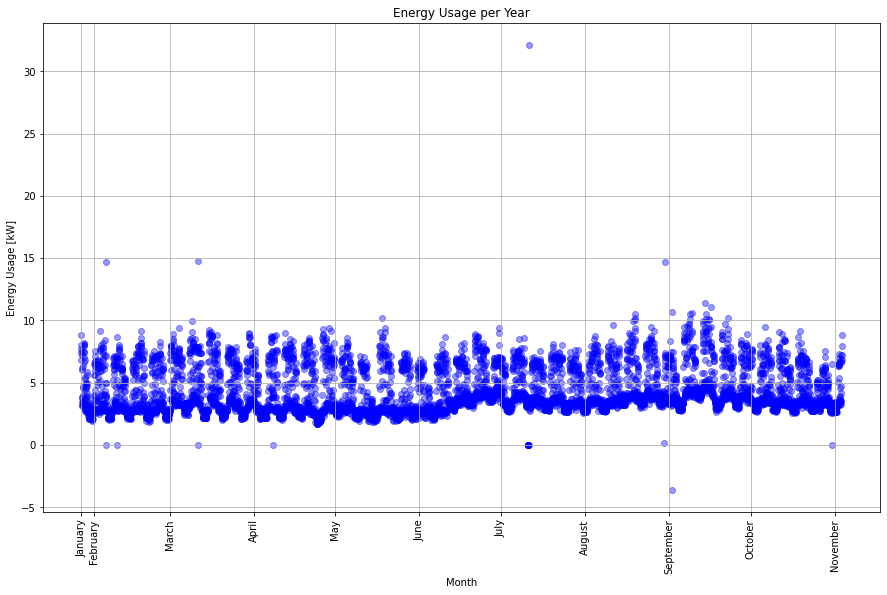

In [8]:
fig = plt.figure(figsize=(15,9))
plt.scatter(DataFrame.index,DataFrame['Energy Usage'],alpha=0.4,color="blue")
plt.grid() 
plt.title("Energy Usage per Year")
plt.xlabel('Month')
plt.ylabel("Energy Usage [kW]")
plt.xticks([1,112,784,1527,2247,2991,3711,4455,5199,5919,6664,], #the sample (=hour counting)  when the month start
           ['January','February','March','April',"May","June","July","August","September","October","November"],
           rotation=90)
plt.savefig("./Imgs/Energy_usage_year.png",transparent=True)


#### Energy Usage distribution

<Figure size 432x288 with 0 Axes>

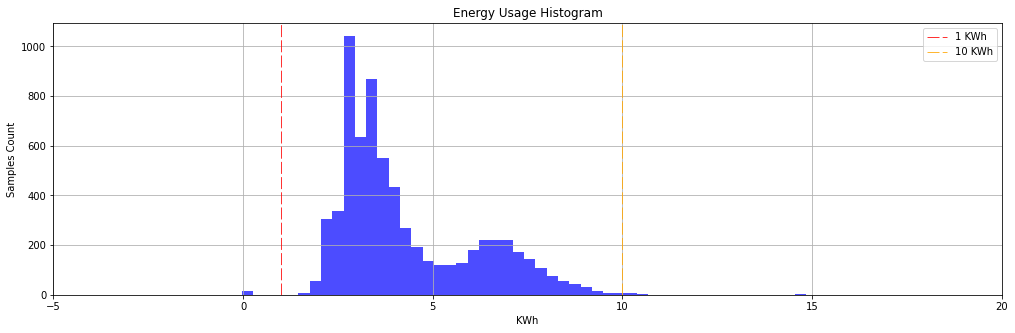

In [9]:
plt.figure()
plt.figure(figsize=(17, 5))
plt.hist(DataFrame['Energy Usage'], bins=120,color='blue',alpha=0.7) 
plt.axvline(x=1, ymin=0, ymax=1, linestyle=':',lw=0.8, color='r' , dashes=(15, 4), label = "1 KWh")
plt.axvline(x=10, ymin=0, ymax=1, linestyle=':',lw=0.8, color='orange' , dashes=(15, 4), label = "10 KWh")

plt.xlabel("KWh")
plt.ylabel("Samples Count")
plt.grid('--')
plt.title("Energy Usage Histogram")
plt.savefig("./Imgs/Energy_usage_histogram.png",transparent=True)
plt.xlim([-5,20])
plt.legend()
plt.show()

* Zoom

<Figure size 432x288 with 0 Axes>

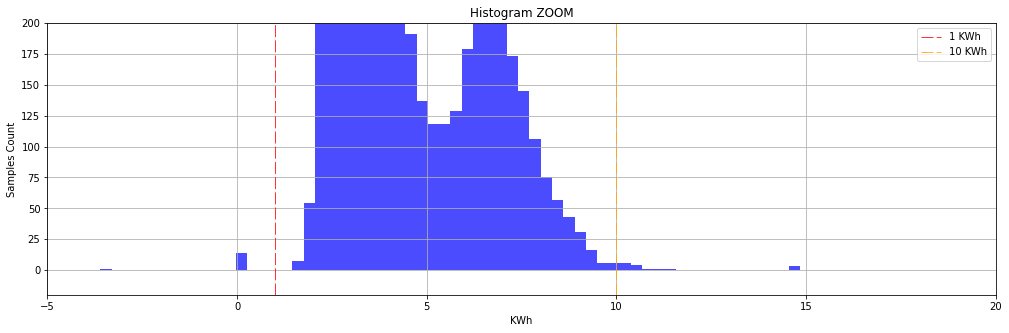

In [10]:
plt.figure()
plt.figure(figsize=(17, 5))
plt.hist(DataFrame['Energy Usage'], bins=120,color='blue',alpha=0.7) 
plt.axvline(x=1, ymin=0, ymax=1, linestyle=':',lw=0.8, color='r' , dashes=(15, 4), label = "1 KWh")
plt.axvline(x=10, ymin=0, ymax=1, linestyle=':',lw=0.8, color='orange' , dashes=(15, 4), label = "10 KWh")

plt.xlabel("KWh")
plt.ylabel("Samples Count")
plt.grid('--')

plt.title("Histogram ZOOM")
plt.xlim([-5,20])
plt.ylim([-20,200])
plt.legend()
plt.savefig("./Imgs/Energy_usage_histogram_zoom.png",transparent=True)

plt.show()


* Gaussian vs our *Energy Usage* distribution

<Figure size 432x288 with 0 Axes>

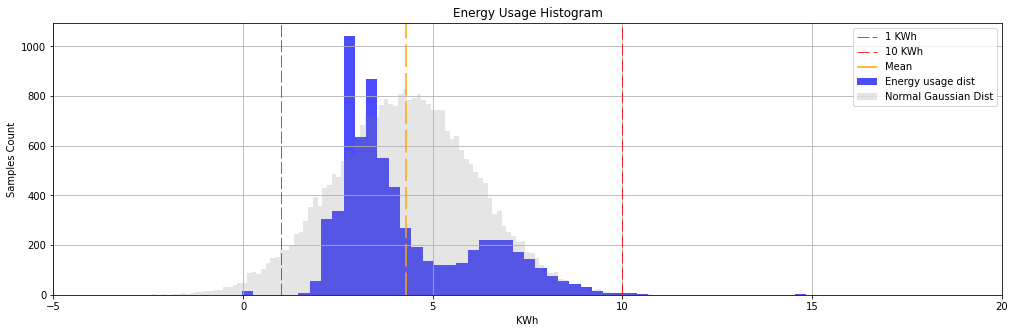

In [11]:
mu = np.mean(DataFrame['Energy Usage'])
std = np.std(DataFrame['Energy Usage'])

datos = np.random.normal(mu, std, 30000) 

plt.figure()
plt.figure(figsize=(17, 5))
plt.hist(DataFrame['Energy Usage'], bins=120,color='blue',alpha=0.7,label="Energy usage dist") 
plt.hist(datos,bins=120,alpha=.2,color='gray',lw=.75,linestyle=':',label="Normal Gaussian Dist")

plt.axvline(x=1, ymin=0, ymax=1, linestyle=':',lw=0.8, color='r' , dashes=(15, 4), label = "1 KWh")
plt.axvline(x=10, ymin=0, ymax=1, linestyle=':',lw=0.8, color='red' , dashes=(15,5 ), label = "10 KWh")
plt.axvline(x=mu, ymin=0, ymax=1, linestyle='--',lw=1.5, color='orange' , dashes=(15, 4), label = "Mean")

plt.xlabel("KWh")
plt.ylabel("Samples Count")
plt.grid('--')
plt.title("Energy Usage Histogram")
plt.savefig("./Imgs/Energy_usage_histogram_gaussian.png",transparent=True)
plt.xlim([-5,20])
plt.legend()
plt.show()


### Finding the anomalies with Gaussian method 

We've considered anomalies the data point outside of 4sigma of the normal gaussian distribution. 
More explanation ...


we consider 0 (not a oulier) as anamolie

* We create a function `find_anomalies` to detect the anomalies and return the value and the location of each of them on the data frame


In [46]:
def find_anomalies_gaussian(data):
    #define a list to accumlate anomalies
    anomalies = []
    idx_anomalies = []
    
   
    # Set upper and lower limit to 4 standard deviation
    data_std = np.std(data)
    data_mean = np.mean(data)
    anomaly_cut_off = data_std * 4
    lower_limit  = data_mean - anomaly_cut_off 
    upper_limit = data_mean + anomaly_cut_off

    # Generate outliers
    for idx,outlier in enumerate(data):
        if outlier > upper_limit or outlier < lower_limit or outlier ==0: 
            anomalies.append(outlier)
            idx_anomalies.append(idx)
          
        
    return anomalies, idx_anomalies


In [47]:
anomalies, idx_anomalies = find_anomalies_gaussian(DataFrame["Energy Usage"])
print("Found ", len(anomalies),"values : ", anomalies)
print("Located on indx: ",idx_anomalies)

Found  18 values :  [0.0, 14.7, 0.0, 0.0, 14.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.1, 14.7, -3.6, 0.0]
Located on indx:  [217, 218, 320, 1034, 1035, 1695, 3949, 3950, 3951, 3952, 3953, 3954, 3955, 3956, 3957, 5158, 5222, 6639]


### Finding the anomalies with a rule based method


Since our energy reading distribution it's not equal as a gaussian, we uses predefined rules to find the anomalies 

 - Negatives values: The energy consumption can't be less than zero 

 - Ceros values: It could be a wrong reading. The energy consumption shouldn't be that low 

 - Unlogical values (too small or too big)

We plot the energy readings to find these rules and the values for each, manually 

#### Energy usage per year

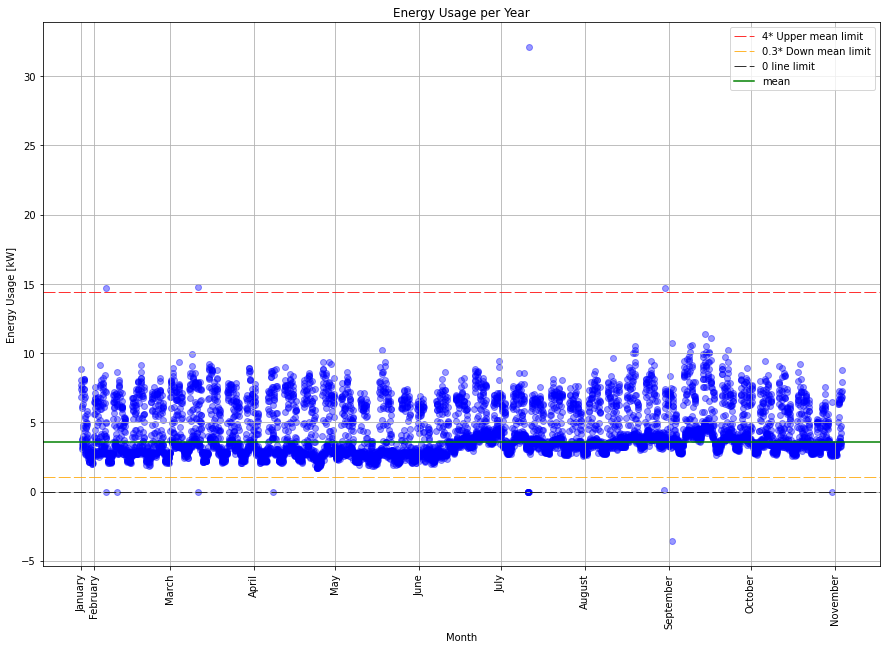

In [48]:
#Calculate the median value 
median = np.median(DataFrame['Energy Usage'])
Updes=4
Dwdes=0.3

fig = plt.figure(figsize=(15,10))


plt.axhline(y=Updes*median, xmin=0, xmax=1, label = str(Updes) + '* Upper mean limit', 
            linestyle=':',lw=0.8, color='r' , dashes=(15, 4))
plt.axhline(y=Dwdes*median, xmin=0, xmax=1, label = str(Dwdes)+ '* Down mean limit',
            linestyle=':',lw=0.8, color='orange', dashes=(15, 4))
plt.axhline(y=0, xmin=0, xmax=1, label = "0 line limit", linestyle=':',lw=0.8, color='k'
            ,dashes=(15, 4))
plt.axhline(y=median, xmin=0, xmax=1, label = "mean", linestyle='-',lw=1.5, color='green')

plt.scatter(DataFrame.index,DataFrame['Energy Usage'],alpha=0.4,color="blue")
plt.grid() 
plt.title("Energy Usage per Year")
plt.xlabel('Month')
plt.ylabel("Energy Usage [kW]")
plt.xticks([1,112,784,1527,2247,2991,3711,4455,5199,5919,6664,], #the sample (=hour counting)  when the month start
           ['January','February','March','April',"May","June","July","August","September","October","November"],
           rotation=90)
plt.legend()
plt.savefig("./Imgs/Energy_usage_year_annotated.png",transparent=True)

#### Energy usage per week

* We transform the string timestamp into datetime type objects

In [49]:
from datetime import datetime as dt 
def Convertstr2dt(data,col): 
    dates=[]
    for str_date in data[col]: 
        dti = dt.strptime(str_date, "%Y-%m-%d %H:%M:%S")
        dates.append(dti)
   
    #Delete the old column
    data.drop(col, inplace = True, axis=1) 

    #Insert the newone
    data.insert(0, col,dates)
    return data

DataFrame = Convertstr2dt(DataFrame,'Time')

In [84]:
import calendar 

def PlotWeek(df, MonthNum,year=2021): 
    x = []
    y = [] 
    Ndays = []  #Number of the Day
    Weekdays=[] #Number of the Day of the Week 
    DayChangeidx = [] 
    
    for idx,value in enumerate(df["Time"]):
        if value.month == MonthNum: 
            x.append(df["Energy Usage"][idx])
            y.append(idx)
            if Ndays and (Ndays[len(Ndays)-1] != value.day):  #We compare with the last one to only save the changes
                Ndays.append(value.day)
                Weekdays.append(value.strftime("%A"))
                DayChangeidx.append(idx)
            elif not Ndays:  #The firs time that we append a value
                Ndays.append(value.day)
                Weekdays.append(value.strftime("%A"))
                DayChangeidx.append(idx)
            
    print(Ndays,Weekdays)  
    #Ndays = pd.unique(Ndays)
    #Weekdays = pd.unique(Weekdays)  We only save the changes on the for now, to get the indx numbe 
    

    fig=plt.figure(figsize=(15,8))
    plt.grid()
    plt.xticks(DayChangeidx,Weekdays ,rotation=90)
    plt.title("Week of month " + str(MonthNum))
    plt.xticks()
    #plt.scatter(y,x,alpha=1,color='#FFC300',lw=1.5)
    #plt.plot(y,x,alpha=0.8, color='blue', lw="0.75",linestyle=":")

    plt.plot(y,x,alpha=0.8, color='blue', lw="0.75",linestyle="--", marker="o",markersize=8)
    plt.ylabel("Energy KWh")
    plt.savefig("./Imgs/Energy_usage_month" + str(MonthNum)+".png",transparent=True)

[27, 28, 29, 30, 31] ['Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']


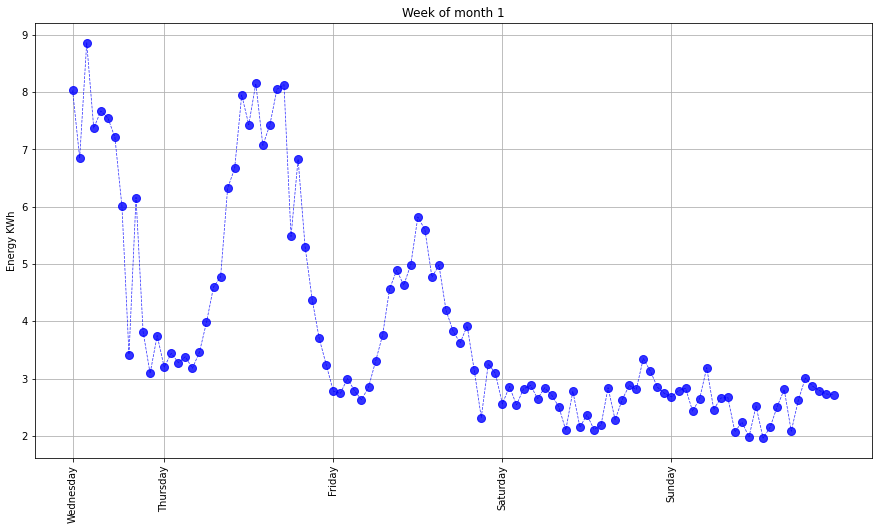

In [87]:

PlotWeek(DataFrame,1)

#### Energy Usage in a day 

In [88]:
def Plotday(df,day, MonthNum,year=2021): 
    x = []
    y = [] 

    for idx,value in enumerate(df["Time"]):
        if value.month == MonthNum and value.day == day: 
            x.append(df["Energy Usage"][idx])
            y.append(value.hour)
            #print(value.hour)
            
    if not x and not y: 
        print("Missing day")
        return -1 
    
    fig=plt.figure(figsize=(15,8))
    plt.grid()
    plt.title("Daily Energy Usage" + ": " + str(day) + "/" + str(MonthNum))
    plt.plot(y,x,alpha=0.8, color='blue', lw="0.75",linestyle="--", marker="o",markersize=8)
    plt.xlabel("Hour")
    plt.ylabel("Energy KWh")
   
    plt.savefig("./Imgs/Energy_usage_daily" + str(day)+ "_"+ str(MonthNum)+ ".png",transparent=True)

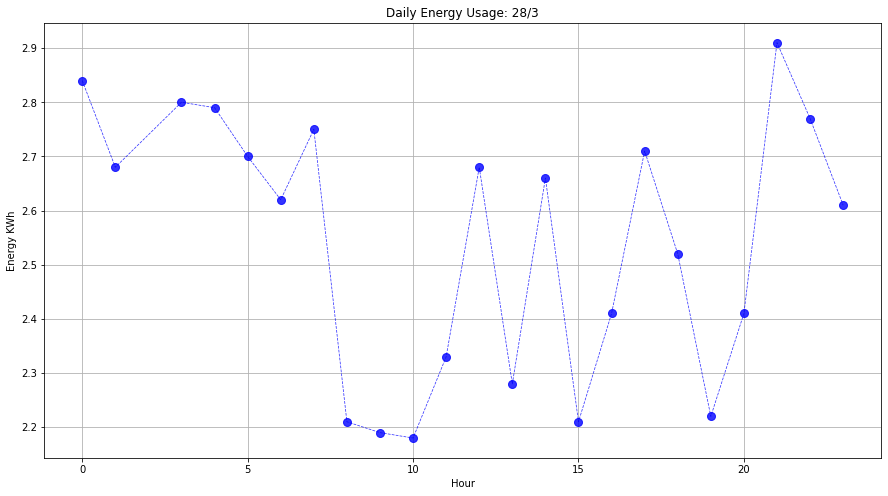

In [89]:
Plotday(DataFrame,28,3)

### Finding the anomalies with these fixed rules 

In [53]:
median = np.median(DataFrame['Energy Usage'])
Updes=4
Dwdes=0.3

anomalies=[]


for value in DataFrame["Energy Usage"]: 
    if value <= 0 or value > Updes*median or value < Dwdes*median: 
        anomalies.append(value)
print("Found: ", len(anomalies))
print("Outliers Values: ", anomalies)

Found:  19
Outliers Values:  [0.0, 14.7, 0.0, 0.0, 14.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.1, 0.14, 14.7, -3.6, 0.0]


### Replacing the anomalies

as we have consecutives values considered anomalies, we can't do linear interpolation (check this) 

* In order to use the built-in function of pandas, we assign a NaN to every anomaly

In [66]:
DataFrame.replace(anomalies,np.nan,inplace= True) 

In [67]:
DataFrame["Energy Usage"][3945:3960]

3945    3.26
3946    3.58
3947    3.80
3948    3.88
3949     NaN
3950     NaN
3951     NaN
3952     NaN
3953     NaN
3954     NaN
3955     NaN
3956     NaN
3957     NaN
3958    3.19
3959    3.20
Name: Energy Usage, dtype: float64

* Using the interpolate function

In [68]:
DataFrame["Energy Usage"].interpolate(method='linear', inplace=True) #or ffil 

In [69]:
DataFrame["Energy Usage"][3945:3960]

3945    3.260
3946    3.580
3947    3.800
3948    3.880
3949    3.811
3950    3.742
3951    3.673
3952    3.604
3953    3.535
3954    3.466
3955    3.397
3956    3.328
3957    3.259
3958    3.190
3959    3.200
Name: Energy Usage, dtype: float64

* Check if we have more anomalies left

In [81]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

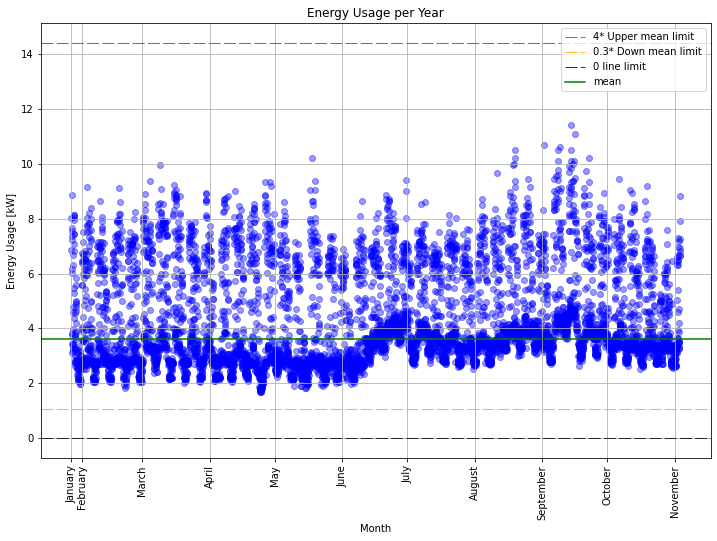

In [78]:
median = np.median(DataFrame['Energy Usage'])
Updes=4
Dwdes=0.3
fig = plt.figure(figsize=(12,8))


plt.axhline(y=Updes*median, xmin=0, xmax=1, label = str(Updes) + '* Upper mean limit', 
            linestyle=':',lw=0.8, color='r' , dashes=(15, 4))
plt.axhline(y=Dwdes*median, xmin=0, xmax=1, label = str(Dwdes)+ '* Down mean limit',
            linestyle=':',lw=0.8, color='orange', dashes=(15, 4))
plt.axhline(y=0, xmin=0, xmax=1, label = "0 line limit", linestyle=':',lw=0.8, color='k'
            ,dashes=(15, 4))
plt.axhline(y=median, xmin=0, xmax=1, label = "mean", linestyle='-',lw=1.5, color='green')

plt.scatter(DataFrame.index,DataFrame['Energy Usage'],alpha=0.4,color="blue")
plt.grid() 
plt.title("Energy Usage per Year")
plt.xlabel('Month')
plt.ylabel("Energy Usage [kW]")
plt.xticks([1,112,784,1527,2247,2991,3711,4455,5199,5919,6664,], #the sample (=hour counting)  when the month start
           ['January','February','March','April',"May","June","July","August","September","October","November"],
           rotation=90)
plt.legend()
plt.savefig("./Imgs/DF_without_anomalies.png",transparent=True)

### Save the pre-processed dataSet of Building Energy consumption 

In [82]:
def SaveDataFrame(data, name): 
    data.to_csv(name,index=False)
    return 

In [83]:
SaveDataFrame(DataFrame,"./DataSets/PreProcessed_EnergyConsumption.csv")